# Trial timings

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import brainbox.behavior.wheel as wh
from brainbox.io.one import SessionLoader
from scipy import stats
from collections import defaultdict
from datetime import datetime
from scipy.stats import pearsonr

from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from design_functions import wheel_velocity
from data_processing import process_quiescence
from wheel_functions import find_periods_below_threshold, create_movement_array, stack_trial_events, wheel_trial_epoch
from one_functions_generic import prepro, query_subjects_interest, subjects_interest_data


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/api.py:1465: UserWarning: Newer cache tables require ONE version 2.7 or greater
  warnings.warn(f'Newer cache tables require ONE version {min_version} or greater')


## Load sessions

In [4]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Wheel/processed/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/processed/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/'
os.chdir(data_path)
data_files = os.listdir(data_path)


## Plot trial snippets

In [2]:
# Get only last session of each animal
data_path =   '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
os.chdir(data_path)
session_all = pickle.load(open(data_path + 'training_2024-04-23', 'rb'))


In [3]:
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Trial_data/'
os.chdir(data_path) 

# Loop through animals
mouse_names = list(session_all.keys())
for m, mouse_name in enumerate(mouse_names[0:1]):

    mouse_name = 'CSHL060'
    # mouse_data = subjects_interest_data(one, [mouse_name], 'learning', 'training')

    # Find data of interest
    mouse_data = pickle.load(open('training_data_trials_'+ mouse_name, "rb"))
    mouse_session_num = np.max(mouse_data['training_day'])
    mouse_session_num = 1
    use_data = mouse_data.loc[mouse_data['training_day'] == mouse_session_num]

    # Loop through sessions
    mouse_sessions = use_data['session'].unique()
    for s, session in enumerate(mouse_sessions):
        
        session_trials = use_data.loc[use_data['session']==session]
        session_trials['index'] = np.arange(0, len(session_trials))

KS014
trial start for expert session: 351
trial start for naive session: ?

CSHL060
trial start for naive 25 (234-278) 
trial start for expert (t = 111 - 131)

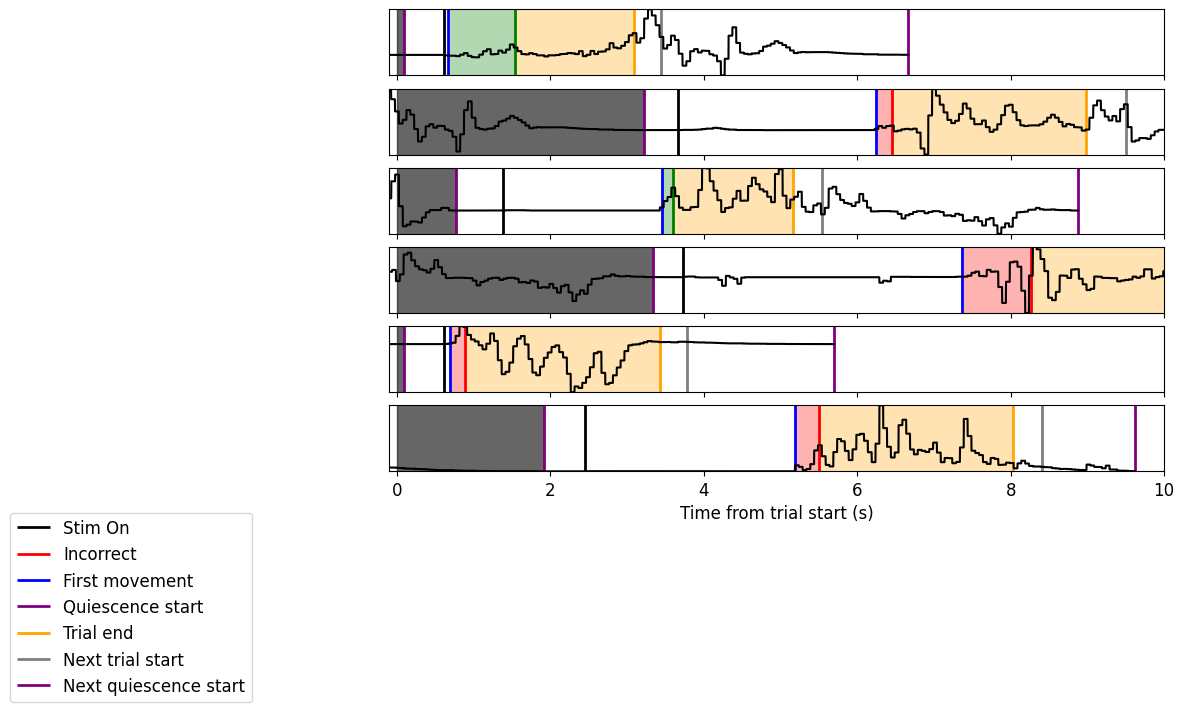

In [31]:
# PLOT
trials_to_plot = 6
time_max = 10
start_trial = 25
session_eid = session
fig, axs = plt.subplots(nrows=trials_to_plot, ncols=1, sharex=True, sharey=False, figsize=[10, 6])
plt.rc('font', size=12)
y = [-10, 10]
bin_size = 0.05
time_min = -0.1
threshold = 0.2 # Need to check if this makes sense
min_period = 400 # This is approximately 200 ms

use_data = session_trials.reset_index()

# Account for naming differences in how data was loaded
if 'quiescencePeriod' in use_data.keys():
    quiescence_name = 'quiescencePeriod'
elif 'quiescence' in use_data.keys():
    quiescence_name = 'quiescence'

for t, trial in enumerate(range(trials_to_plot)):

    trial_start = use_data.loc[use_data['index']==t+start_trial, 'intervals_0']
    next_trial = use_data.loc[use_data['index']==t+start_trial+1]
    trial_data = use_data.loc[use_data['index']==t+start_trial]
    trial_feedback = trial_data['feedbackType']

    axs[t].vlines(np.array(trial_data['stimOn_times']) - trial_start,
                    -10, 10, label='Stim On', color='Black', linewidth=2)
    if list(trial_feedback)[0] == 1:
        axs[t].vlines(np.array(trial_data['feedback_times']) - trial_start,
                    -10, 10, label='Correct', color='Green', linewidth=2)
        axs[t].fill_betweenx(y, list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], 
                        list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='green', alpha=0.3)
        axs[t].fill_betweenx(y, list(trial_data['feedback_times'])[0]-list(trial_start)[0], 
                        list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='green', alpha=0.6)
    else:
        axs[t].vlines(np.array(trial_data['feedback_times']) - trial_start,
                    -10, 10, label='Incorrect', color='Red', linewidth=2)
        axs[t].fill_betweenx(y, list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], 
                        list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='red', alpha=0.3)
        axs[t].fill_betweenx(y, list(trial_data['feedback_times'])[0]-list(trial_start)[0], 
                        list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='red', alpha=0.6)
        
    axs[t].vlines(np.array(trial_data['firstMovement_times']) - trial_start, -10, 10, 
                    label='First movement', color='Blue', linewidth=2)
    axs[t].vlines(np.array((trial_data['goCue_times'] - trial_data[quiescence_name])) - trial_start,
                    -10, 10, label='Quiescence start', color='Purple', linewidth=2)
    # axs[t].vlines(np.array(trial_data['feedback_times']) - trial_start,
    #                 -10, 10, label='Stim Off', color='Brown', linewidth=2)
    axs[t].vlines(np.array(trial_data['intervals_1']) - trial_start,
                    -10, 10, label='Trial end', color='Orange', linewidth=2)
    axs[t].vlines(np.array(next_trial['intervals_0']) - trial_start,
                    -10, 10, label='Next trial start', color='Grey', linewidth=2)  
    axs[t].vlines(np.array((next_trial['goCue_times'] - next_trial[quiescence_name])) - trial_start,
                    -10, 10, label='Next quiescence start', color='Purple', linewidth=2)

    axs[t].fill_betweenx(y, 0, list(trial_data['goCue_times'] - 
                        trial_data[quiescence_name])[0]-list(trial_start)[0], color='black', alpha=0.6)
    # axs[t].fill_betweenx(y, list(trial_data['goCue_times'] - 
    #                     trial_data[quiescence_name])[0]-list(trial_start)[0], 
    #                     list(trial_data['stimOn_times'])[0]-list(trial_start)[0], color='purple', alpha=0.3)
    # axs[t].fill_betweenx(y, list(trial_data['stimOn_times'])[0]-list(trial_start)[0],
    #                         list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], color='black', alpha=0.3)
    axs[t].fill_betweenx(y, list(trial_data['feedback_times'])[0]-list(trial_start)[0],
                            list(trial_data['intervals_1'])[0]-list(trial_start)[0], color='orange', alpha=0.3)
    # axs[t].fill_betweenx(y, list(next_trial['intervals_0'])[0] - list(trial_start)[0], 
    #                         list(next_trial['goCue_times'] - 
    #                     next_trial[quiescence_name])[0]-list(trial_start)[0], color='purple', alpha=0.6)
    
    # Wheel
    wheel_data = one.load_object(session_eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    # Calculate wheel velocity
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, use_data)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    xx = wheel_times - list(trial_start)[0]
    yy = wheel_trace

    trial_time_max = list(np.array(next_trial['goCue_times'] - 
                                    next_trial[quiescence_name]) - trial_start)[0]
    mask = np.where((xx <trial_time_max) & (xx> time_min))
    wheel_max = np.max(wheel_trace[mask])
    wheel_min = np.min(wheel_trace[mask])

    # Plot wheel
    axs[t].plot(xx[mask], yy[mask], color='Black')
    axs[t].set_ylim([wheel_min, wheel_max])
    axs[t].set_yticks([] ,[])
axs[t].set_xlabel(str('Time from trial start (s)'))
axs[t].set_xlim([time_min, time_max])
axs[t].legend(loc='upper left', bbox_to_anchor=(-.5, -0.5))
plt.show()

## Segment into movements and stillnesses

The quiescence in the task is defined as not surpassing 2 degrees of wheel displacement over that specific trial quiescence demand.
For the shortest quiescence demand possible (400 ms), that corresponds to not moving the weehl more than 4 / wh.WHEEL_DIAMETER (0.465).
The corresponding average velocity over 400 ms would be 0.16 radians/ ms.

# Plot timings per different task conditions

In [6]:
# Loop through animals
timings_all = pd.DataFrame()

for f, file in enumerate(data_files):
    if 'processed' in file:
        # Get movement data
        processed_quiescence = pickle.load(open(file, "rb"))      
        timings = pd.DataFrame(processed_quiescence.groupby(['trial', 'feedback', 'next_feedback', 
                                                            'choice', 'time_to_quiesc', 'quiesc_length', 
                                                            'reaction', 'signed_contrast', 'probabilityLeft'])['response'].mean())
        timings = timings.reset_index(level=[0, 1, 2, 3, 4, 5, 6, 7, 8])

        timings['next_choice'] = timings['choice'] * np.nan 
        timings['next_choice'][:-1] = timings['choice'][1:]
        timings['next_reaction'] = timings['reaction'] * np.nan 
        timings['next_reaction'][:-1] = timings['reaction'][1:]
        timings['next_response'] = timings['response'] * np.nan 
        timings['next_response'][:-1] = timings['response'][1:]

        # Remove values if trial skipped
        timings['trial_dif'] = timings['trial']
        timings['trial_dif'][1:] = np.diff(timings['trial'])

        timings.loc[timings['trial_dif']!=1, 'next_choice'] = np.nan 
        timings.loc[timings['trial_dif']!=1, 'next_reaction'] = np.nan 
        timings.loc[timings['trial_dif']!=1, 'next_response'] = np.nan 
        
        timings['Win_stay'] = timings['feedback'] * np.nan
        timings['Lose_shift'] = timings['feedback'] * np.nan
        timings['Lose_stay'] = timings['feedback'] * np.nan
        timings['Win_shift'] = timings['feedback'] * np.nan
        timings['Lose'] = timings['feedback'] * np.nan
        timings['Win'] = timings['feedback'] * np.nan

        timings.loc[(timings['choice']==timings['next_choice']) & 
                            (timings['feedback']==1.), 'Win_stay'] = 1
        timings.loc[(timings['choice']!=timings['next_choice']) & 
                            (timings['feedback']==-1.), 'Lose_shift'] = 1
        timings.loc[(timings['choice']==timings['next_choice']) & 
                            (timings['feedback']==-1.), 'Lose_stay'] = 1
        timings.loc[(timings['choice']!=timings['next_choice']) & 
                            (timings['feedback']==1.), 'Win_shift'] = 1
        
        timings.loc[(timings['choice']!=timings['next_choice']) & 
                            (timings['feedback']==1.), 'Win'] = 1
        timings.loc[(timings['choice']==timings['next_choice']) & 
                            (timings['feedback']==1.), 'Win'] = 0
        timings.loc[(timings['choice']!=timings['next_choice']) & 
                            (timings['feedback']==-1.), 'Lose'] = 1
        timings.loc[(timings['choice']==timings['next_choice']) & 
                            (timings['feedback']==-1.), 'Lose'] = 0
        timings['idx'] = file
        timings['learning_phase'] = file[21:22]

        # Save              
        if len(timings_all) == 0:
            timings_all = timings
        else:
            timings_all = timings_all.append(timings)
    

/tmp/ipykernel_71710/3440489283.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timings['next_choice'][:-1] = timings['choice'][1:]
/tmp/ipykernel_71710/3440489283.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timings['next_reaction'][:-1] = timings['reaction'][1:]
/tmp/ipykernel_71710/3440489283.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timings['next_response'][:-1] = timings['response'][1:]
/tmp/ipykernel_71710

## Session timings overview

/tmp/ipykernel_71710/4173873596.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  use_timings = pd.DataFrame(timings_all.groupby(['feedback', 'learning_phase', 'idx'])['time_to_quiesc', 'quiesc_length'


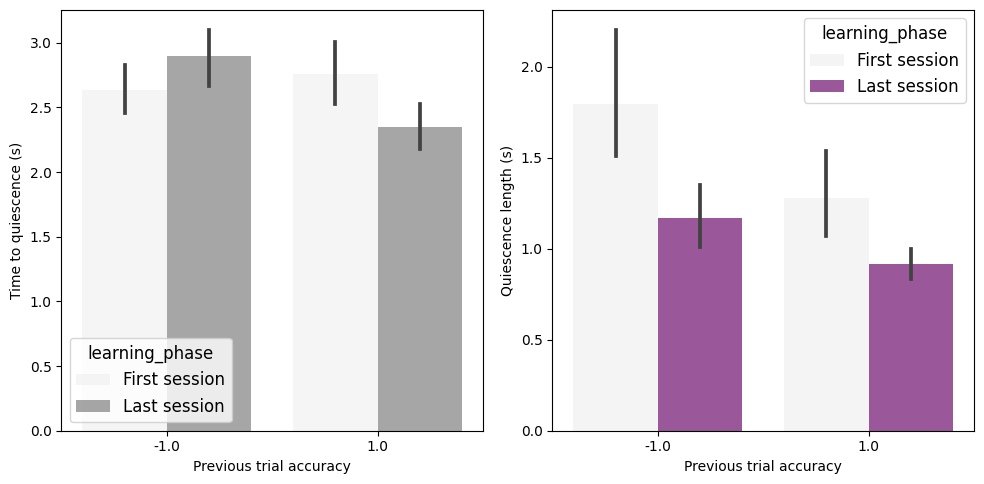

In [7]:
use_timings = pd.DataFrame(timings_all.groupby(['feedback', 'learning_phase', 'idx'])['time_to_quiesc', 'quiesc_length'
                                                    ].median())
use_timings = use_timings.reset_index(level=[0, 1, 2])

use_timings.loc[use_timings['learning_phase'] =='1', 'learning_phase'] = 'First session'
use_timings.loc[use_timings['learning_phase'] =='l', 'learning_phase'] = 'Last session'

vars_to_plot = ['reaction', 'response', 'time_to_quiesc', 'quiesc_length', 
                'next_reaction', 'next_response']
var_names = ['Previous reaction time', 'Previous response time', 'Time to quiescence', 'Quiescence length',
                'Next reaction time',
                'Next response time']

colors = ['orange', 'red', 'grey', 'purple', 'blue', 'violet']

vars_to_plot = ['time_to_quiesc', 'quiesc_length']
var_names = [ 'Time to quiescence (s)',
                'Quiescence length (s)']

colors = ['grey', 'purple']

fig, axs = plt.subplots(nrows=1, ncols=len(vars_to_plot), sharex=False, sharey=False, figsize=[10, 5])

plt.rc('font', size=12)
for v, var in enumerate(vars_to_plot):
    
    # sns.barplot(y=var, x='probabilityLeft', data=timings, ax=axs[4, v], color='black', alpha=0.5)
    # axs[4, v].set_ylabel(var_names[v])
    # axs[4, v].set_xlabel('Block left')
    sns.barplot(y=var, x='feedback', data=use_timings, hue='learning_phase', ax=axs[v], color=colors[v], alpha=.7)
    # else:
    #     sns.barplot(y=var, x='feedback', data=use_timings, hue='learning_phase', ax=axs[v], color=colors[v], alpha=.8)
    # sns.barplot(y=var, x='next_feedback', data=use_timings, hue='learning_phase', ax=axs[v], color=colors[v], alpha=0.5)

    axs[v].set_ylabel(var_names[v])

    axs[v].set_xlabel('Previous trial accuracy')
    plt.tight_layout()
    
    # sns.barplot(y=var, x='Win', data=use_timings, ax=axs[2, v], hue='learning_phase', color=colors[v], alpha=0.5)
    # sns.barplot(y=var, x='Lose', data=use_timings, ax=axs[3, v], hue='learning_phase', color=colors[v], alpha=0.5)

    # axs[2, v].set_ylabel(var_names[v])
    # axs[3, v].set_ylabel(var_names[v])

    # axs[2, v].set_xlabel('Win shift')
    # axs[3, v].set_xlabel('Lose shift')

plt.tight_layout()
# plt.show()

# Save the plot as a PNG file
# plt.savefig(str(save_path + session + 'timing_quant.png'), format='png')   


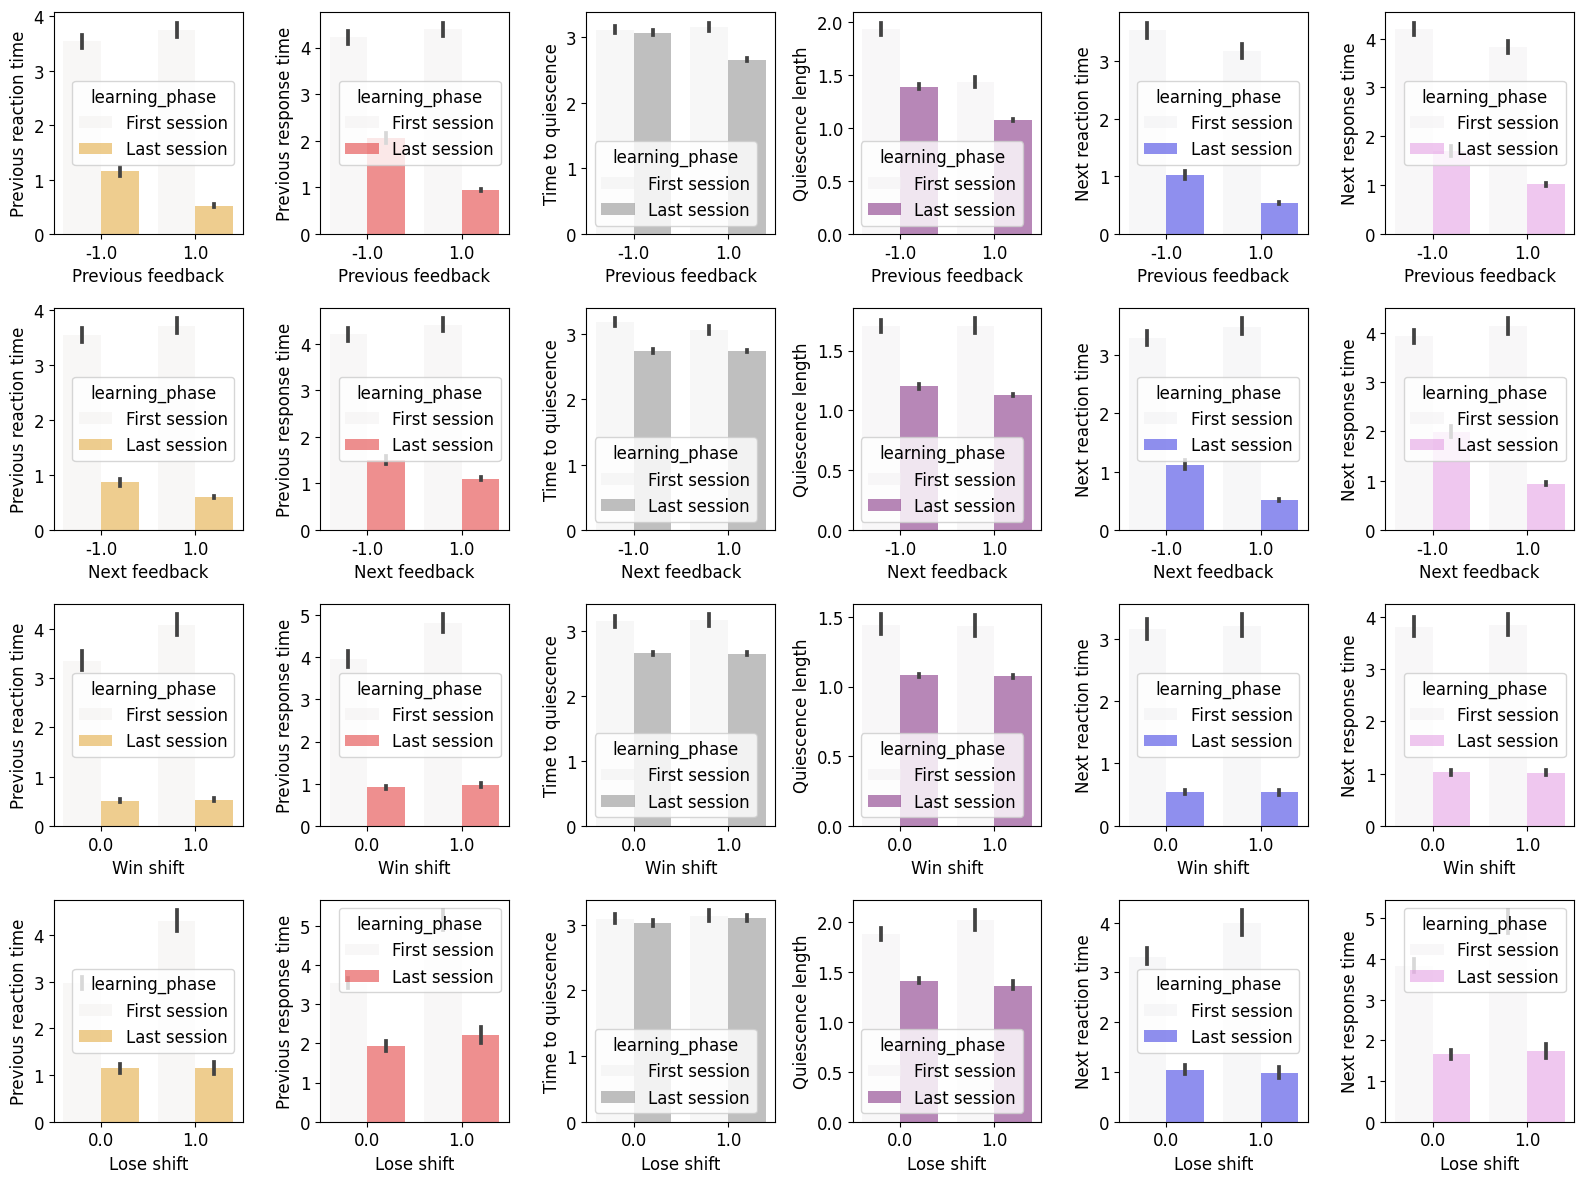

In [8]:
# use_timings = pd.DataFrame(timings_all.groupby(['trial', 'idx', 'next_feedback', 'feedback',
#                                                     'choice', 'signed_contrast', 'probabilityLeft',
#                                                     'Win', 'Lose', 'learning_phase'])['time_to_quiesc', 'time_to_quiesc',
#                                                     'reaction', 'response', 'next_reaction', 'next_response'
#                                                     ].mean())
# use_timings = use_timings.reset_index(level=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
use_timings = timings_all.copy()
use_timings.loc[use_timings['learning_phase'] =='1', 'learning_phase'] = 'First session'
use_timings.loc[use_timings['learning_phase'] =='l', 'learning_phase'] = 'Last session'

vars_to_plot = ['reaction', 'response', 'time_to_quiesc', 'quiesc_length', 
                'next_reaction', 'next_response']
var_names = ['Previous reaction time', 'Previous response time', 'Time to quiescence', 'Quiescence length',
                'Next reaction time',
                'Next response time']
colors = ['orange', 'red', 'grey', 'purple', 'blue', 'violet']
fig, axs = plt.subplots(nrows=4, ncols=len(vars_to_plot), sharex=False, sharey=False, figsize=[16, 12])

plt.rc('font', size=12)
for v, var in enumerate(vars_to_plot):
    
    # sns.barplot(y=var, x='probabilityLeft', data=timings, ax=axs[4, v], color='black', alpha=0.5)
    # axs[4, v].set_ylabel(var_names[v])
    # axs[4, v].set_xlabel('Block left')

    sns.barplot(y=var, x='feedback', data=use_timings, hue='learning_phase', ax=axs[0, v], color=colors[v], alpha=0.5)
    sns.barplot(y=var, x='next_feedback', data=use_timings, hue='learning_phase', ax=axs[1, v], color=colors[v], alpha=0.5)

    axs[0, v].set_ylabel(var_names[v])
    axs[1, v].set_ylabel(var_names[v])

    axs[0, v].set_xlabel('Previous feedback')
    axs[1, v].set_xlabel('Next feedback')
    plt.tight_layout()
    
    sns.barplot(y=var, x='Win', data=use_timings, ax=axs[2, v], hue='learning_phase', color=colors[v], alpha=0.5)
    sns.barplot(y=var, x='Lose', data=use_timings, ax=axs[3, v], hue='learning_phase', color=colors[v], alpha=0.5)

    axs[2, v].set_ylabel(var_names[v])
    axs[3, v].set_ylabel(var_names[v])

    axs[2, v].set_xlabel('Win shift')
    axs[3, v].set_xlabel('Lose shift')

plt.tight_layout()

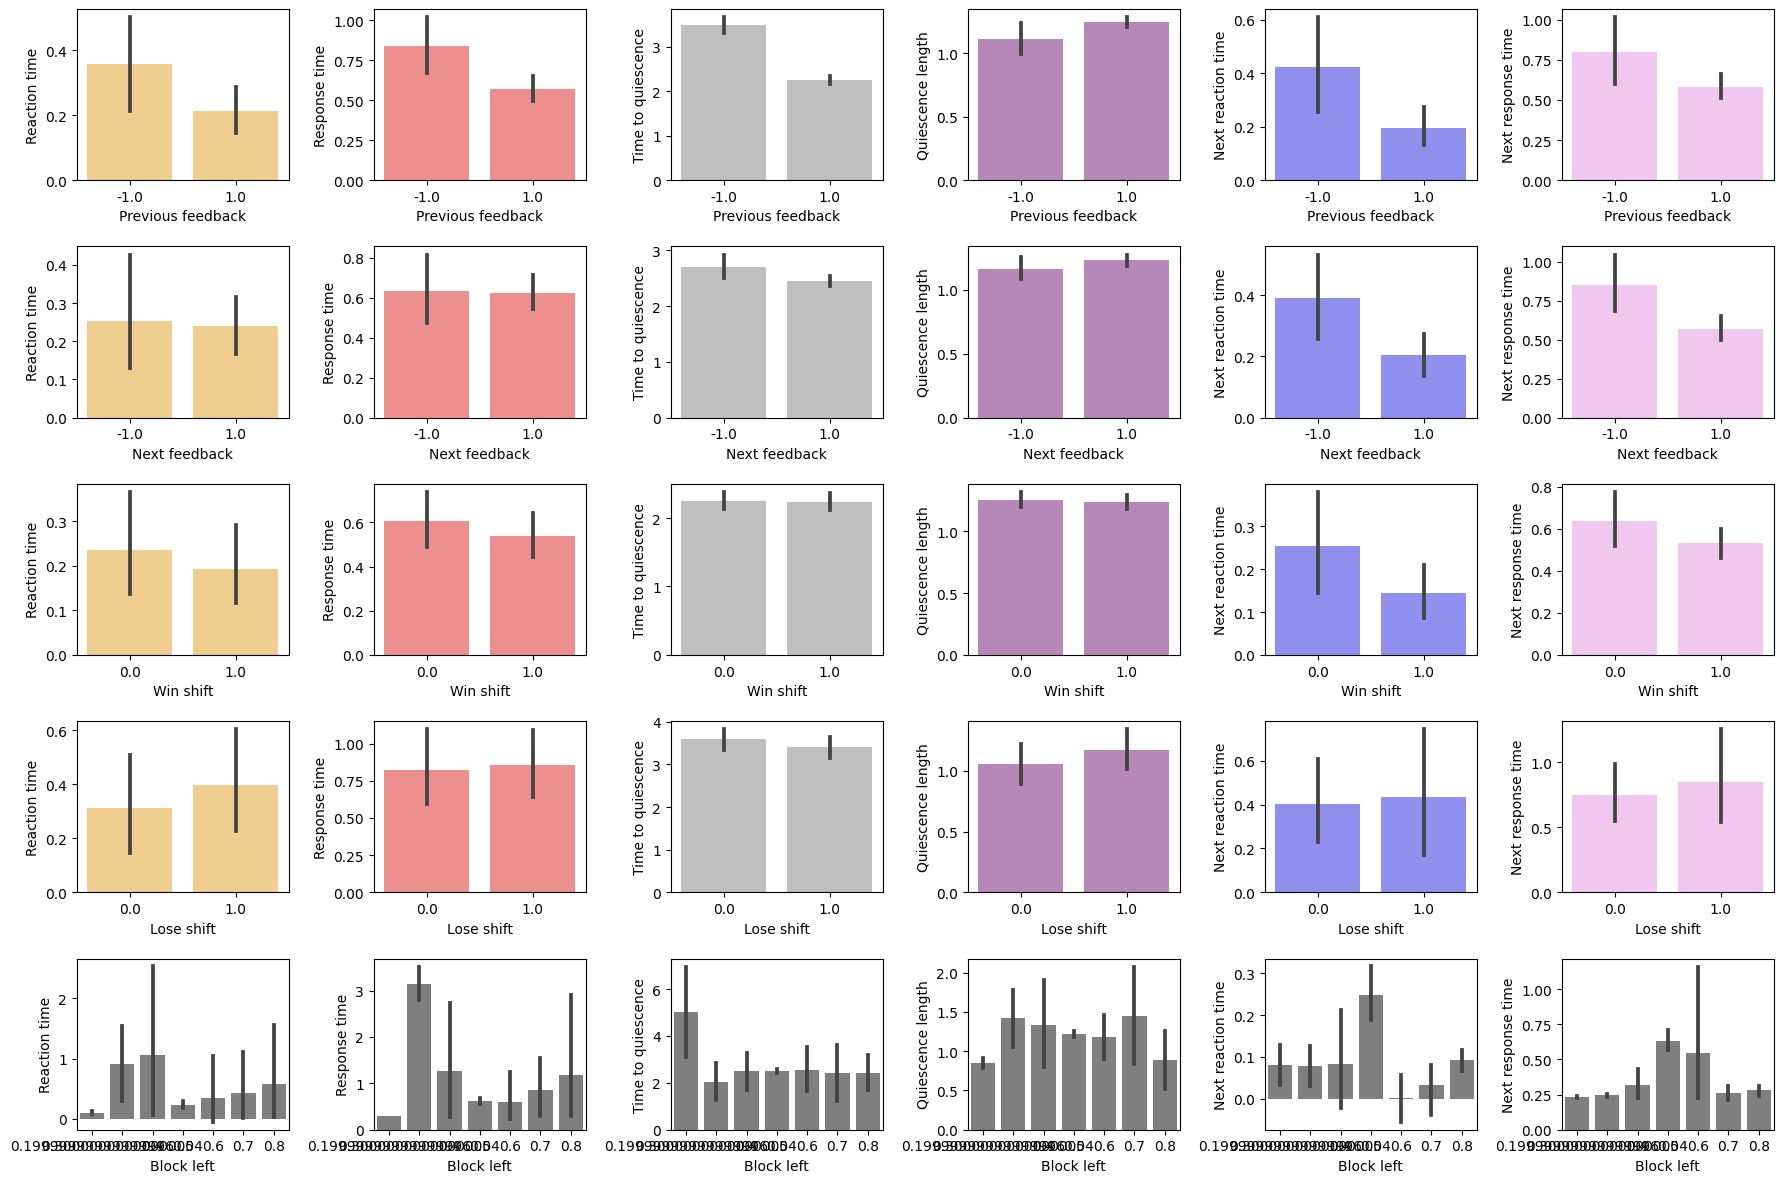

In [14]:
# Plot each session
all_sessions = timings_all['idx'].unique()
for s, session in enumerate(all_sessions):
    
    timings = timings_all.loc[timings_all['idx']==session]

    # PLOT
    vars_to_plot = ['reaction', 'response', 'time_to_quiesc', 'quiesc_length', 
                    'next_reaction', 'next_response']
    var_names = ['Previous reaction time', 'Previous response time', 'Time to quiescence', 'Quiescence length',
                 'Next reaction time',
                 'Next response time']
    colors = ['orange', 'red', 'grey', 'purple', 'blue', 'violet']
    fig, axs = plt.subplots(nrows=5, ncols=len(vars_to_plot), sharex=False, sharey=False, figsize=[18, 12])

    plt.rc('font', size=12)
    for v, var in enumerate(vars_to_plot):
        
        sns.barplot(y=var, x='probabilityLeft', data=timings, ax=axs[4, v], color='black', alpha=0.5)
        axs[4, v].set_ylabel(var_names[v])
        axs[4, v].set_xlabel('Block left')

        sns.barplot(y=var, x='feedback', data=timings, ax=axs[0, v], color=colors[v], alpha=0.5)
        sns.barplot(y=var, x='next_feedback', data=timings, ax=axs[1, v], color=colors[v], alpha=0.5)

        axs[0, v].set_ylabel(var_names[v])
        axs[1, v].set_ylabel(var_names[v])

        axs[0, v].set_xlabel('Previous feedback')
        axs[1, v].set_xlabel('Next feedback')
        plt.tight_layout()
        
        sns.barplot(y=var, x='Win', data=timings, ax=axs[2, v], color=colors[v], alpha=0.5)
        sns.barplot(y=var, x='Lose', data=timings, ax=axs[3, v], color=colors[v], alpha=0.5)

        axs[2, v].set_ylabel(var_names[v])
        axs[3, v].set_ylabel(var_names[v])

        axs[2, v].set_xlabel('Win shift')
        axs[3, v].set_xlabel('Lose shift')

    plt.tight_layout()
    # plt.show()
    
    # Save the plot as a PNG file
    # plt.savefig(str(save_path + session + 'timing_quant.png'), format='png')   


### Correlates of session performance

0.2793965448102801
0.6737296996043673
0.41065073032538474
0.48434542537214204


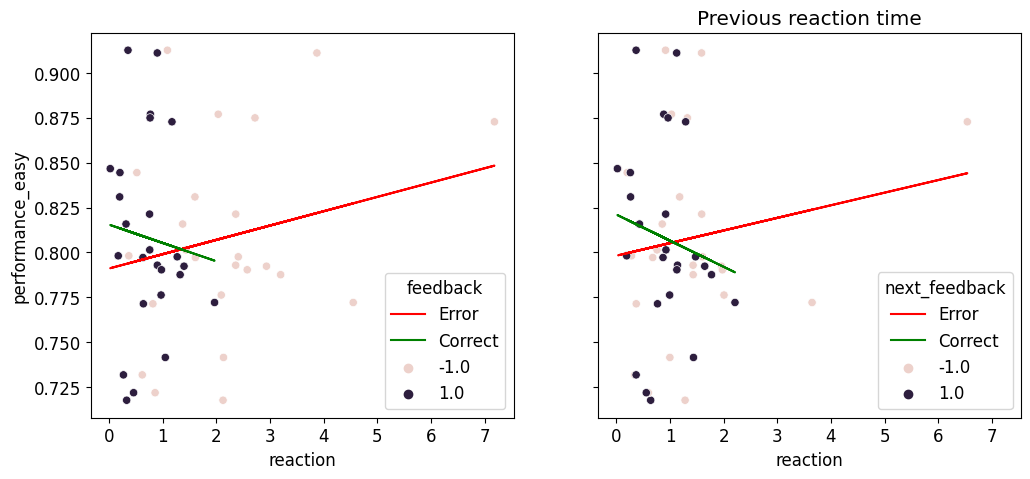

0.20086695798290008
0.22620569138250796
0.7555942444001802
0.3105931290199091


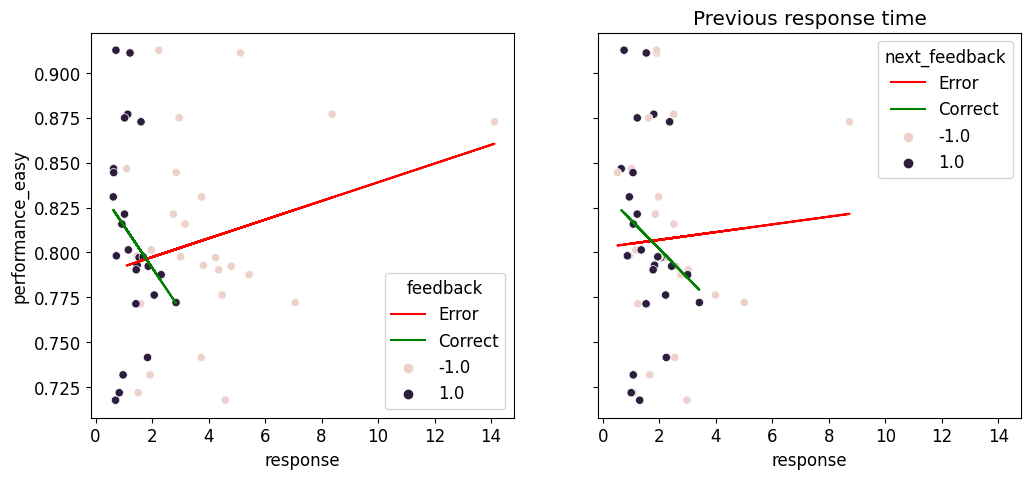

0.28643993111280325
0.9373557730744861
0.8326004940297249
0.9941766089598726


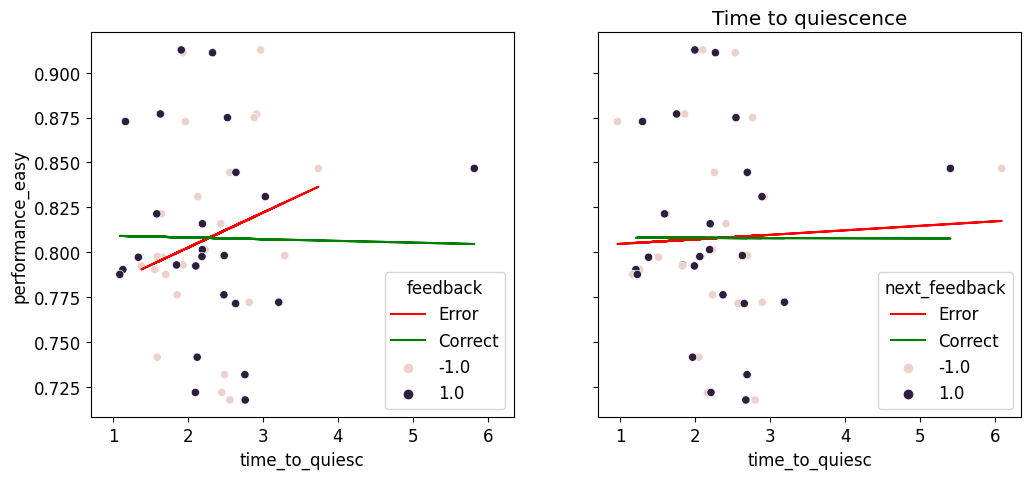

0.33886066799674963
0.5334905038469605
0.7342389765752879
0.79647288767663


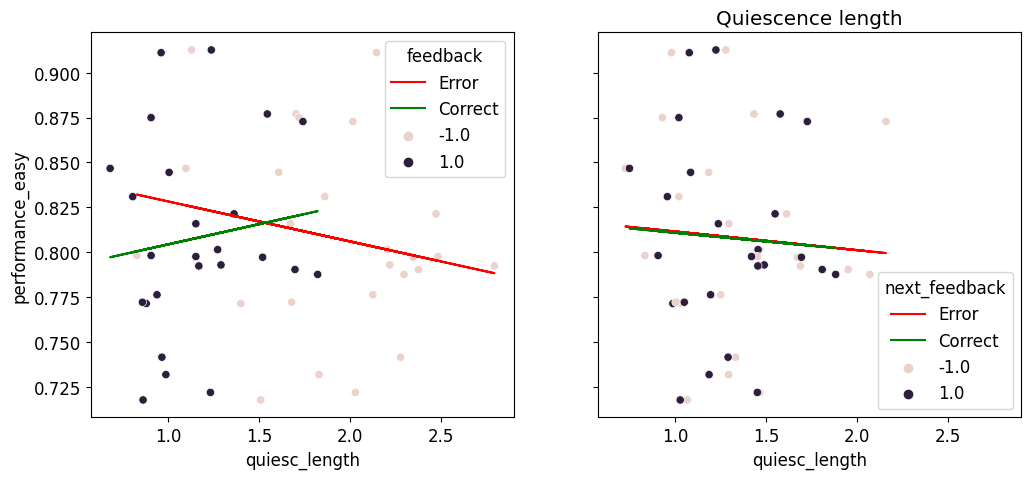

0.8192641047649005
0.7035602361298697
0.3715971630008991
0.7048415580663758


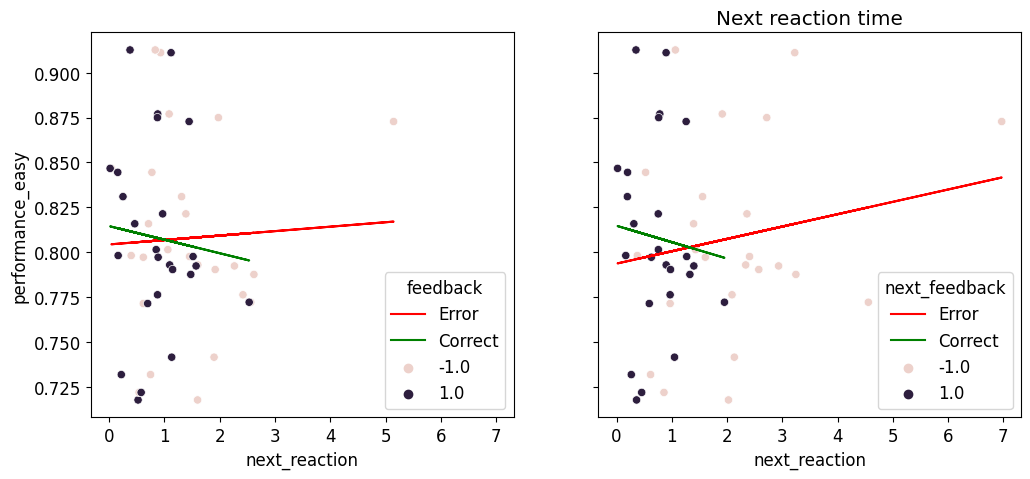

0.940257929011697
0.3665627166529485
0.3406574870774334
0.3192869421306821


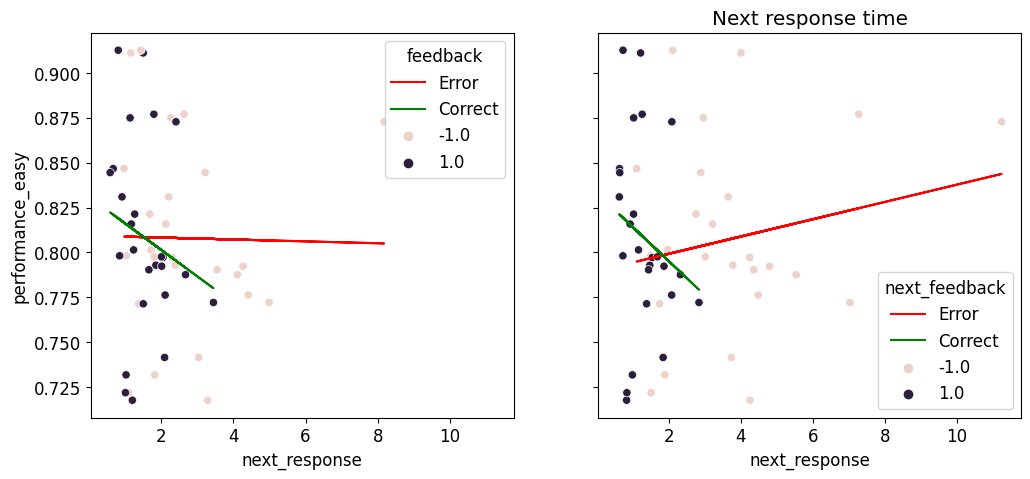

In [23]:
joint_df = timings_all.merge(perf_idx, on=['idx'])
# vars = ['time_to_quiesc', 'quiesc_length']
# var_names = ['Time to quiescence', 'Quiescence length']
vars = ['reaction', 'response', 'time_to_quiesc', 'quiesc_length', 'next_reaction', 'next_response']
var_names = ['Previous reaction time', 'Previous response time', 
             'Time to quiescence', 'Quiescence length', 
             'Next reaction time', 'Next response time']
hues = ['feedback', 'next_feedback']
for v, var in enumerate(vars):
    
    # use_data = joint_df.loc[joint_df['var']==var]    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[12, 5])

    
    use_data = joint_df.groupby(['idx', 'performance_easy', 'feedback']).mean([var]).reset_index()
    # Fit a linear regression line
    x = use_data.loc[use_data['feedback']==-1., var]
    y = use_data.loc[use_data['feedback']==-1., 'performance_easy']
    slope, intercept = np.polyfit(x, y, 1)
    correlation_coefficient, p_value = pearsonr(x, y)
    print(p_value)

    # Plot the regression line
    axs[0].plot(x, slope*x + intercept, color='red', label='Error')
    x = use_data.loc[use_data['feedback']==1., var]
    y = use_data.loc[use_data['feedback']==1., 'performance_easy']
    slope, intercept = np.polyfit(x, y, 1)
    correlation_coefficient, p_value = pearsonr(x, y)
    print(p_value)

    # Plot the regression line
    axs[0].plot(x, slope*x + intercept, color='green', label='Correct')
    sns.scatterplot(x=var, y='performance_easy', hue='feedback', data=use_data, ax=axs[0])

    use_data = joint_df.groupby(['idx', 'performance_easy', 'next_feedback']).mean([var]).reset_index()
    # Fit a linear regression line
    x = use_data.loc[use_data['next_feedback']==-1., var]
    y = use_data.loc[use_data['next_feedback']==-1., 'performance_easy']
    slope, intercept = np.polyfit(x, y, 1)
    correlation_coefficient, p_value = pearsonr(x, y)
    print(p_value)
    # Plot the regression line
    axs[1].plot(x, slope*x + intercept, color='red', label='Error')

    x = use_data.loc[use_data['next_feedback']==1., var]
    y = use_data.loc[use_data['next_feedback']==1., 'performance_easy']
    slope, intercept = np.polyfit(x, y, 1)
    axs[1].plot(x, slope*x + intercept, color='green', label='Correct')
    sns.scatterplot(x=var, y='performance_easy', hue='next_feedback', data=use_data, ax=axs[1])
    correlation_coefficient, p_value = pearsonr(x, y)
    print(p_value)
    plt.title(var_names[v])
    # axs[0].set_xticks([0, 1, 2, 3], ['Quiescence', 'Stimulus', 'Choice', 'ITI'], rotation=45)  # Orient x-axis ticks at 45 degrees
    plt.tight_layout
    plt.show()
    

### Trial timings illustration

In [18]:
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/'
os.chdir(data_path)
df = pickle.load(open('wheel_movements_last_0ca2bfb2-0724-43a9-b485-6e45e101e71c', "rb"))
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/processed/'
os.chdir(data_path)
processed_quiescence = pickle.load(open('processed_quiescence_last_0ca2bfb2-0724-43a9-b485-6e45e101e71c', "rb"))
# CSHL060
# Naive: 32088c28-be54-4e32-9f8e-a03c4f85c6d0
# Expert: 0ca2bfb2-0724-43a9-b485-6e45e101e71c	

In [63]:
trial_data

,index,trial,trial_epoch,feedback,next_feedback,signed_contrast,movement,response,reaction,choice,probabilityLeft,movement_onset,epoch_onset,movement_duration,quiesc_length,time_to_quiesc,time_to_quiesc_2,pre_quiesc_move_duration,pre_quiesc_move_count
453,212486,50,trial_start,1.0,1.0,-0.9375,0.0,0.2316,0.032638,1.0,0.5,210.109638,210.109638,0.359,0.626,2.647,0.601,2.199,1
454,212827,50,trial_start,1.0,1.0,-0.9375,1.0,0.2316,0.032638,1.0,0.5,210.450638,210.109638,0.341,0.626,2.647,0.601,2.199,1
455,213527,50,trial_start,1.0,1.0,-0.9375,0.0,0.2316,0.032638,1.0,0.5,211.150638,210.109638,0.700,0.626,2.647,0.601,2.199,1
456,213977,50,trial_start,1.0,1.0,-0.9375,1.0,0.2316,0.032638,1.0,0.5,211.600638,210.109638,0.450,0.626,2.647,0.601,2.199,1
457,214777,50,trial_start,1.0,1.0,-0.9375,0.0,0.2316,0.032638,1.0,0.5,212.400638,210.109638,0.800,0.626,2.647,0.601,2.199,1
458,215577,50,quiescence,1.0,1.0,-0.9375,0.0,0.2316,0.032638,1.0,0.5,213.200638,213.200638,0.800,0.626,2.647,0.601,2.199,1
459,216020,50,stim_on,1.0,1.0,-0.9375,0.0,0.2316,0.032638,1.0,0.5,213.643638,213.643638,0.443,0.626,2.647,0.601,2.199,1
460,216081,50,movement,1.0,1.0,-0.9375,0.0,0.2316,0.032638,1.0,0.5,213.704638,213.704638,0.061,0.626,2.647,0.601,2.199,1
461,216127,50,movement,1.0,1.0,-0.9375,1.0,0.2316,0.032638,1.0,0.5,213.750638,213.704638,0.046,0.626,2.647,0.601,2.199,1
462,216280,50,post_choice,1.0,1.0,-0.9375,1.0,0.2316,0.032638,1.0,0.5,213.903638,213.903638,0.153,0.626,2.647,0.601,2.199,1


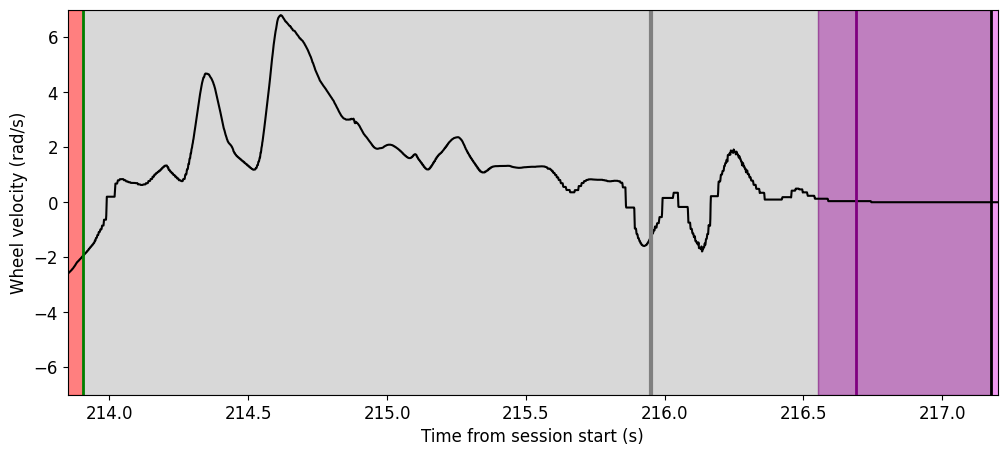

In [74]:
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/raw_traces_1/'
trials = processed_quiescence.trial.unique()
new_df = df.copy()
dt = list(df['time'])[1] - list(df['time'])[0]
new_df['wheel_vel'] = np.gradient(new_df['wheel_pos'], dt)
for t, trial in enumerate(trials[50:51]):

    trial_data = processed_quiescence.loc[processed_quiescence['trial']==trial]
    next_trial = processed_quiescence.loc[processed_quiescence['trial']==trial+1]
    
    feedback = list(trial_data['feedback'])[0]
    next_feedback = list(trial_data['next_feedback'])[0]
    contrast = list(trial_data['signed_contrast'])[0]
    
    # stimOn = list(next_trial.loc[next_trial['trial_epoch']=='stim_on', 'epoch_onset'])[0]
    quiescence = list(next_trial.loc[next_trial['trial_epoch']=='quiescence', 'epoch_onset'])[0]
    time_to_quiescence = list(trial_data['time_to_quiesc'])[0]
    time_to_quiescence2 = list(trial_data['time_to_quiesc_2'])[0]
    quiesc_length = list(trial_data['quiesc_length'])[0]

    trial_start = list(next_trial.loc[next_trial['trial_epoch']=='trial_start', 'epoch_onset'])[0]
    stim_on =  next_trial.loc[next_trial['trial_epoch']=='stim_on', 'epoch_onset']
    movement_on = list(next_trial.loc[next_trial['trial_epoch']=='movement', 'epoch_onset'])[0]
    response = list(next_trial.loc[next_trial['trial_epoch']=='post_choice', 'epoch_onset'])[0]
    
    last_stim_on =  trial_data.loc[trial_data['trial_epoch']=='stim_on', 'epoch_onset']
    last_movement_on = list(trial_data.loc[trial_data['trial_epoch']=='movement', 'epoch_onset'])[0]
    last_response = list(trial_data.loc[trial_data['trial_epoch']=='post_choice', 'epoch_onset'])[0]


    plt.figure(figsize=[12, 5])
    # plt.figure(figsize=[14, 5])

    plt.fill_betweenx([-7, 7], list(last_stim_on)[0], last_movement_on, color='orange', alpha=0.5)
    plt.fill_betweenx([-7, 7], last_movement_on, last_response , color='red', alpha=0.5)

    plt.fill_betweenx([-7, 7], last_response, last_response + time_to_quiescence, color='gray', alpha=0.3)
    plt.fill_betweenx([-7, 7], movement_on, response, color='pink', alpha=0.8)

    if len(stim_on)>0:
        plt.fill_betweenx([-7, 7], last_response + time_to_quiescence, list(stim_on)[0], color='purple', alpha=0.5)
        plt.fill_betweenx([-7, 7], list(stim_on)[0], movement_on , color='violet', alpha=0.8)
        plt.vlines(list(stim_on)[0], -7, 7, color='black', label='Stimulus onset', linewidth=2)
    else:
        plt.fill_betweenx([-7, 7], last_response + time_to_quiescence, movement_on, color='purple', alpha=0.5)

    plt.plot(new_df['time'], new_df['wheel_vel'], color='black')

    plt.vlines(list(last_stim_on)[0], -7, 7, color='black', label='Stimulus onset', linewidth=2)
    plt.vlines(movement_on, -7, 7, color='blue', label='Movement onset', linewidth=2)
    plt.vlines(trial_start, -7, 7, color='gray', label='Trial start', linewidth=3)
    plt.vlines(quiescence, -7, 7, color='purple', label='Quiescence start', linewidth=2)

    plt.vlines(last_movement_on, -7, 7, color='blue', linewidth=2)
    if feedback == 1.:
        plt.vlines(last_response, -7, 7, color='green', label='Correct response', linewidth=2)
    else:
        plt.vlines(last_response, -7, 7, color='red', label='Incorrect response', linewidth=2)
    if next_feedback == 1.:
        plt.vlines(response, -7, 7, color='green', label='Correct response', linewidth=2)
    else:
        plt.vlines(response, -7, 7, color='red', label='Incorrect response', linewidth=2)


    plt.xlim([list(trial_data['movement_onset'])[0]+3, list(next_trial['movement_onset'])[-1]+1])
    plt.xlim([list(next_trial['movement_onset'])[-1]-2, list(next_trial['movement_onset'])[-1]+1])
    plt.xlim([22.5, 27.5])
    plt.xlim([213.85, 217.2])

    plt.ylim([-7, 7])
    plt.xlabel('Time from session start (s)')
    plt.ylabel('Wheel velocity (rad/s)')

    time_to_quiesc = np.round(list(trial_data['time_to_quiesc'])[0], 2)
    quiesc_length = np.round(list(trial_data['quiesc_length'])[0], 2)
    # plt.title('Trial ' + str(trial) + ' Time to quiesc = ' + str(time_to_quiesc) + ' Quiesc = ' + str(quiesc_length) + 'Contrast = ' + str(contrast))
    # plt.title('Trial ' + str(trial))
    # plt.legend(loc='upper left', bbox_to_anchor=(1,0.5))
    # plt.show()
    # plt.savefig(str(save_path + session + str(trial) + 'quiescence_trial.png'), format='png')   



## Analyze stillness and movement periods

d32876dd-8303-4720-8e7e-20678dc2fd71
72982282-e493-45ee-87ce-aa45cb3a3ec1
6434f2f5-6bce-42b8-8563-d93d493613a2
64e3fb86-928c-4079-865c-b364205b502e
15948667-747b-4702-9d53-354ac70e9119
288bfbf3-3700-4abe-b6e4-130b5c541e61
fc43390d-457e-463a-9fd4-b94a0a8b48f5
3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b


/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


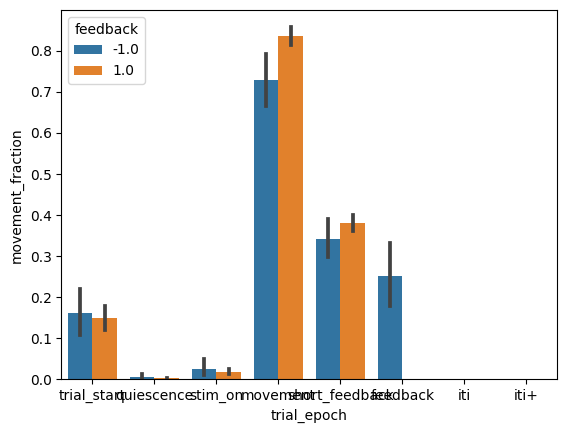

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


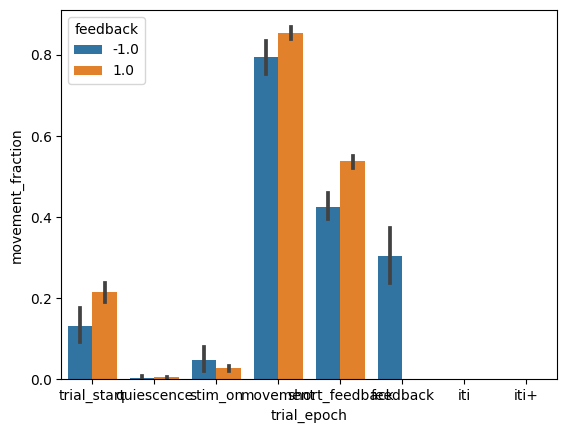

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


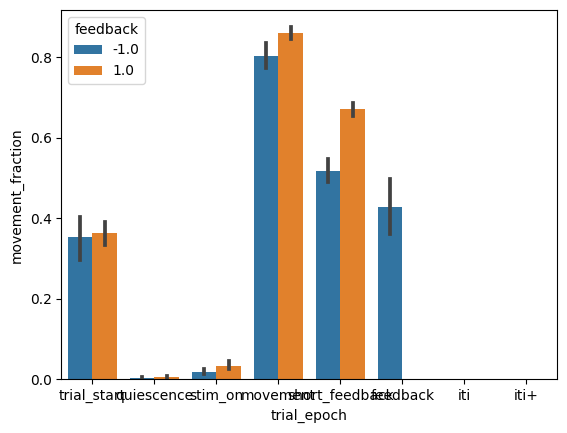

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


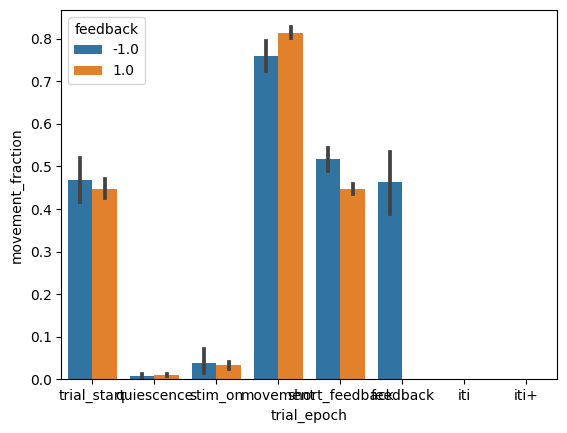

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


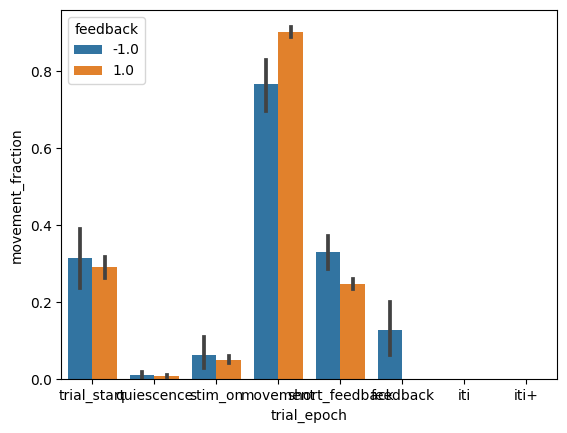

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


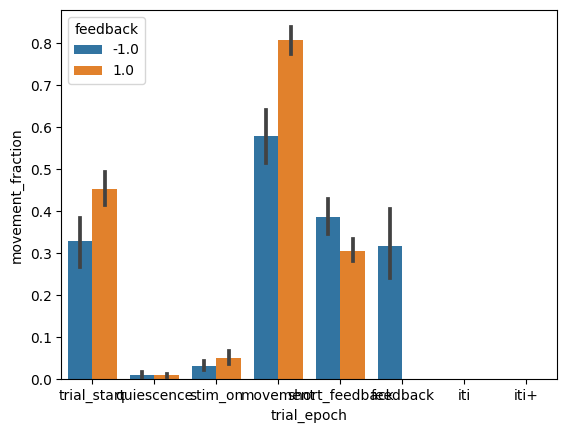

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


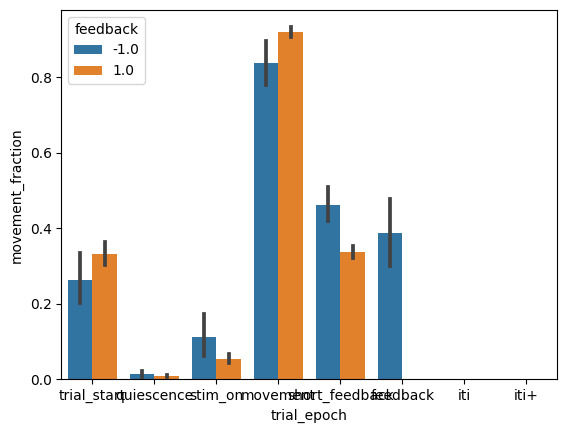

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.9kB/s]
/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


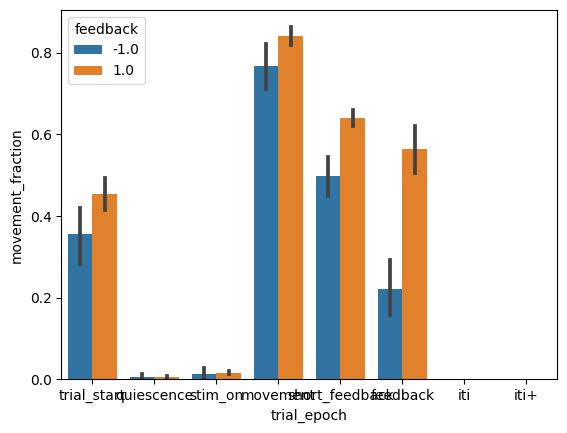

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


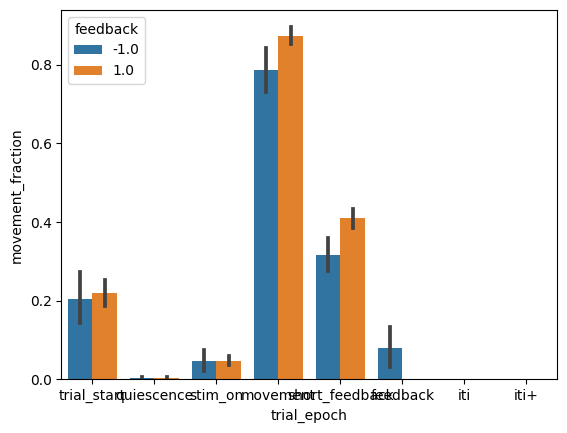

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


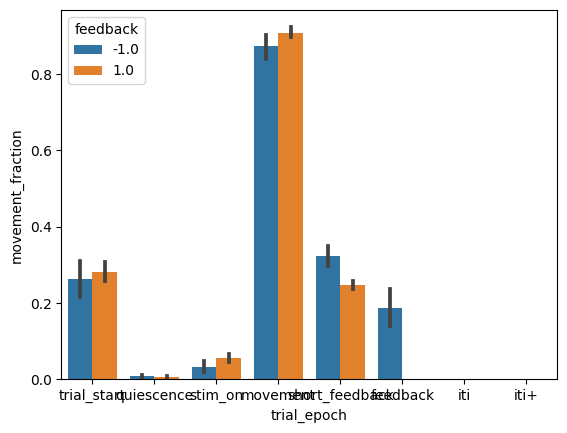

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


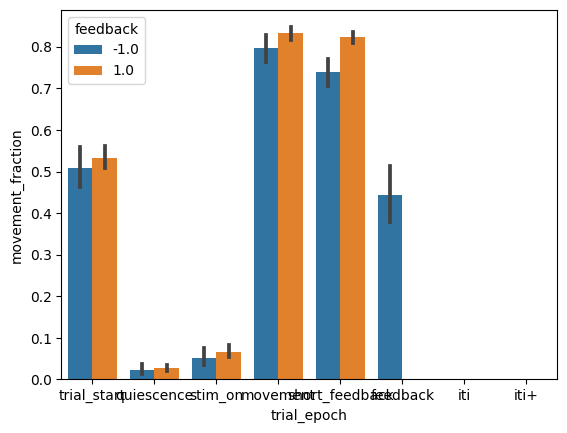

f312aaec-3b6f-44b3-86b4-3a0c119c0438


In [115]:
for s, session in enumerate(pass_qc['session_uuid'][10:]):
    try:
        # Get trials
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        
        bin_size = 0.05
        df = wheel_trial_epoch(one, session_trials, session, bin_size).dropna()
        df['time_count'] = np.ones(len(df['movement']))
        
        mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())
        mean_label = mean_label.reset_index(level=[0, 1, 2, 3])
        mean_label['movement_fraction'] = mean_label['movement'] / mean_label['time_count']
        
        # Stilness per trial epoch
        var_order = ['trial_start', 'quiescence', 'stim_on', 'movement', 'short_feedback', 'feedback', 'iti', 'iti+']
        sns.barplot(x='trial_epoch', hue='feedback', y = 'movement_fraction', data=mean_label, order=var_order)
        # plt.ylim([0, 1])
        plt.show()
    except:
        print(session)
